1.916079036000631e+17
-1.442372529737758e+18
0.9950634566078557
0.9901512826763739


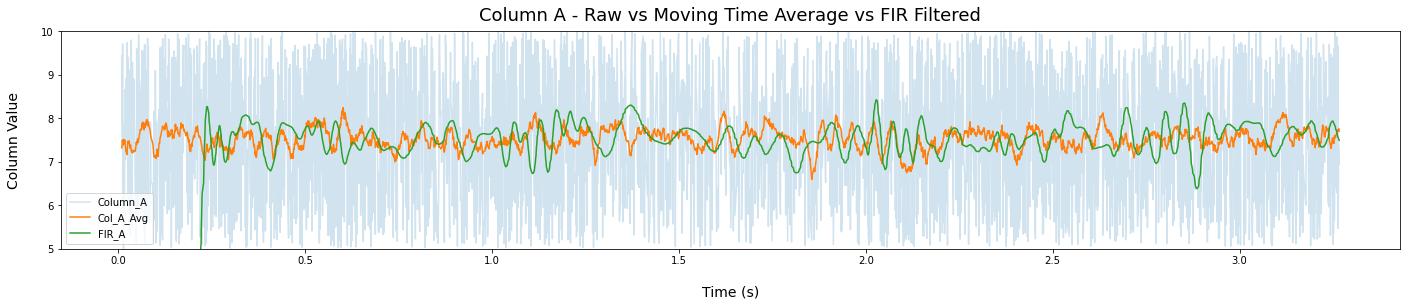

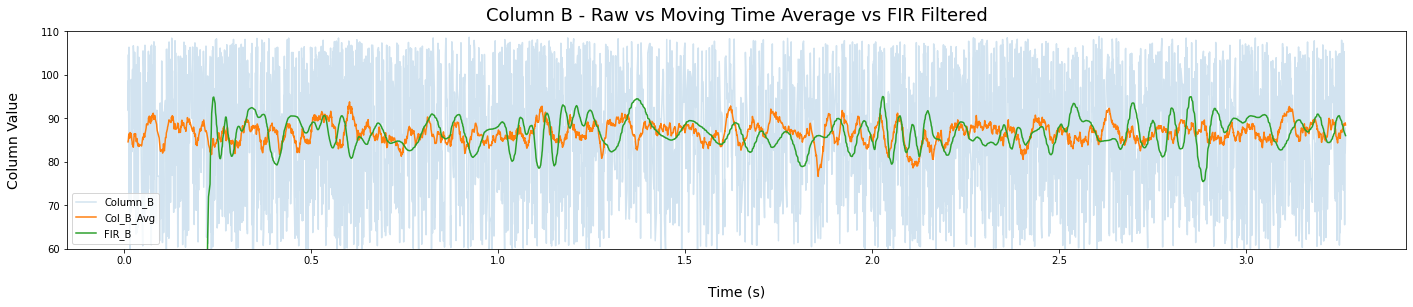

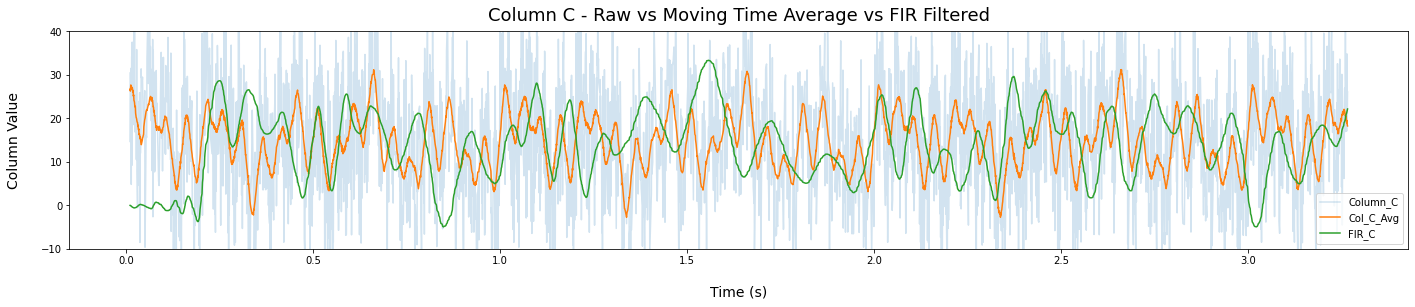

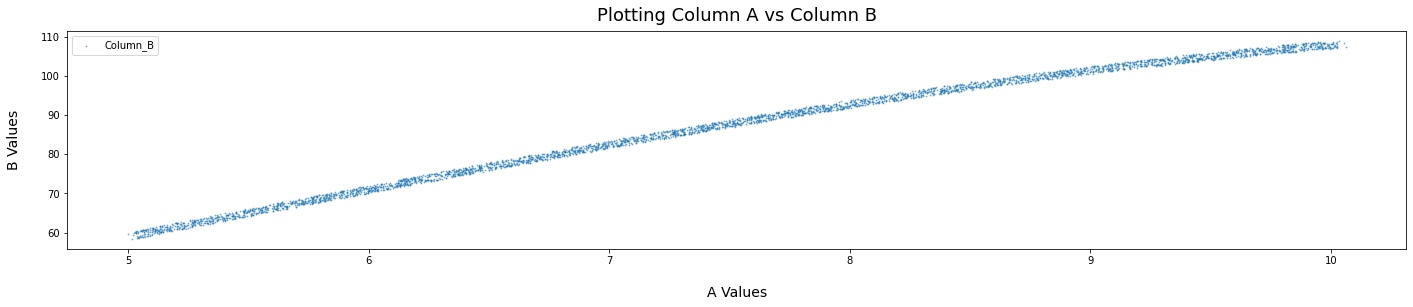

In [3]:
#Importing Libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
# pd.set_option('display.max_rows',None)

pd.set_option('display.width', 1000)

#######################################################################################

#Loading CSV into DataFrame
df_testdata = pd.read_csv(f"{sys.path[0]}/TestData.csv")

#Computing 50 point moving average

#Empty Storage Vector
data = []

#Loop through all the times in Test Data Set
for i in range(df_testdata.shape[0]-50):
    
    #50 Point Separated Index
    idx1 = i
    idx2 = i+50

    #Calculate 50 point Mean in Time
    time = df_testdata.loc[idx1:idx2,'Time (s)'].mean()
    mov_avgA = df_testdata.loc[idx1:idx2,'Column_A'].mean()
    mov_avgB = df_testdata.loc[idx1:idx2,'Column_B'].mean()
    mov_avgC = df_testdata.loc[idx1:idx2,'Column_C'].mean()

    #Append all the data into list on each pass
    data.append([time,mov_avgA,mov_avgB,mov_avgC])

#Transform Lists into DataFrame Structure
df_avg = pd.DataFrame(data, columns=['Time (s)','Col_A_Avg','Col_B_Avg','Col_C_Avg'])

#Finite Impulse Response (FIR) - Passing Filter Through Dataset
sample_rate = 5000
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0
# The desired width of the transition from pass to stop,
# relative to the Nyquist rate. 
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 15.0
# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 100.0
# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter on data - Pass FIR filter and load result into dataframe
filtered_a = pd.DataFrame(lfilter(taps, 1.0,df_testdata['Column_A']),columns = ["FIR_A"])
filtered_b = pd.DataFrame(lfilter(taps, 1.0,df_testdata['Column_B']),columns = ["FIR_B"])
filtered_c = pd.DataFrame(lfilter(taps, 1.0,df_testdata['Column_C']),columns = ["FIR_C"])

#Combining Original Data + Computed Dataframes
df_combine = pd.merge(df_testdata,df_avg)
df_combine = pd.merge(df_combine,filtered_a, left_index = True, right_index = True)
df_combine = pd.merge(df_combine,filtered_b, left_index = True, right_index = True)
df_combine = pd.merge(df_combine,filtered_c, left_index = True, right_index = True)

#Computing Simple Linear Regression of A vs B plot
#A = x and B = y
#Computing Sx,Sxx,Sy,Syy and Sxy

df_testdata['Sxx'] = df_testdata['Column_A']**2
df_testdata['Syy'] = df_testdata['Column_B']**2
df_testdata['Sxy'] = df_testdata['Column_A']*df_testdata['Column_B']

# print(df_testdata)

n = df_testdata.shape[0]
# print(n)
Sx_A   = df_testdata['Column_A'].sum()
Sxx_A  = df_testdata['Sxx'].sum()
Sy_B   = df_testdata['Column_B'].sum()
Syy_B  = df_testdata['Syy'].sum()
Sxy_AB = df_testdata['Sxy'].sum()

beta = (n * Sxy_AB - Sx_A*Sy_B)*(n*Sxx_A-Sx_A**2)
alpha = Sy_B/n - beta*Sx_A/n

print(beta)
print(alpha)


#R value
r = (n*Sxy_AB - Sx_A*Sy_B)/(np.sqrt((n*Sxx_A-Sx_A**2)*(n*Syy_B-Sy_B**2)))
r_sqrd = r**2
print(r)
print(r_sqrd)

xi= np.array([5,10])
y= xi*beta+alpha


#######################################################################################
# # Raw Data plot Column vs Time  
# plt.figure()
# df_testdata.reset_index().plot(x = "Time (s)", y = ["Column_A", "Column_B", "Column_C"],kind="line",figsize=(24, 4),fontsize=14)
# title_str = "Raw Data Column A/B/C" 
# plt.xlabel("Time (s)", labelpad=20,fontsize=14)
# plt.ylabel("Column Value", labelpad=20,fontsize=14)
# plt.title(title_str, y=1.02,fontsize=18);
# plt.show()

# #Plotting Time Averaged Data
# plt.figure()
# df_avg.plot(x = 'Time (s)', y = ['Col_A_Avg','Col_B_Avg','Col_C_Avg'],kind="line",figsize=(24, 4),fontsize=14)
# title_str = "Time Averaged Data: A/B/C" 
# plt.xlabel("Time (s)", labelpad=20,fontsize=14)
# plt.ylabel("Column Value", labelpad=20,fontsize=14)
# plt.title(title_str, y=1.02,fontsize=18);
# plt.show()

# #Plotting all the FIR Filtered Data
# plt.figure()
# df_combine.plot(x = 'Time (s)',y = ['FIR_A','FIR_B','FIR_C'],kind="line",figsize=(24, 4),fontsize=14)
# title_str = "FIR Filtered Data: A/B/C" 
# plt.xlabel("Time (s)", labelpad=20,fontsize=14)
# plt.ylabel("Column Value", labelpad=20,fontsize=14)
# plt.title(title_str, y=1.02,fontsize=18);
# ax = plt.gca()
# # ax.set_ylim([5,11])
# plt.show()
#######################################################################################

#Column A - Raw vs Moving Time Average vs FIR Filtered
plt.figure(figsize=(24, 4))
ax = plt.gca()
plt.plot('Time (s)','Column_A',data = df_combine,alpha = 0.2)
plt.plot('Time (s)','Col_A_Avg',data = df_combine)
plt.plot('Time (s)','FIR_A',data = df_combine)
title_str = "Column A - Raw vs Moving Time Average vs FIR Filtered" 
plt.xlabel("Time (s)", labelpad=20,fontsize=14)
plt.ylabel("Column Value", labelpad=20,fontsize=14)
plt.title(title_str, y=1.02,fontsize=18);
plt.legend()
ax.set_ylim([5,10])
plt.show()

#Column B - Raw vs Moving Time Average vs FIR Filtered
plt.figure(figsize=(24, 4))
ax = plt.gca()
plt.plot('Time (s)','Column_B',data = df_combine,alpha = 0.2)
plt.plot('Time (s)','Col_B_Avg',data = df_combine)
plt.plot('Time (s)','FIR_B',data = df_combine)
title_str = "Column B - Raw vs Moving Time Average vs FIR Filtered" 
plt.xlabel("Time (s)", labelpad=20,fontsize=14)
plt.ylabel("Column Value", labelpad=20,fontsize=14)
plt.title(title_str, y=1.02,fontsize=18);
plt.legend()
ax.set_ylim([60,110])
plt.show()

#Column C - Raw vs Moving Time Average vs FIR Filtered
plt.figure(figsize=(24, 4))
ax = plt.gca()
plt.plot('Time (s)','Column_C',data = df_combine,alpha = 0.2)
plt.plot('Time (s)','Col_C_Avg',data = df_combine)
plt.plot('Time (s)','FIR_C',data = df_combine)
title_str = "Column C - Raw vs Moving Time Average vs FIR Filtered" 
plt.xlabel("Time (s)", labelpad=20,fontsize=14)
plt.ylabel("Column Value", labelpad=20,fontsize=14)
plt.title(title_str, y=1.02,fontsize=18);
plt.legend()
ax.set_ylim([-10,40])
plt.show()

# Plot Column A vs Column B
# plt.figure()
# df_testdata.plot(x = "Column_A", y = "Column_B",kind="scatter",figsize=(24, 4),fontsize=14,s=0.05)
# title_str = "Plotting Column A vs Column B" 
# plt.xlabel("Column A", labelpad=20,fontsize=14)
# plt.ylabel("Column B", labelpad=20,fontsize=14)
# plt.title(title_str, y=1.02,fontsize=18);
# plt.show()

#Column C - Raw vs Moving Time Average vs FIR Filtered
plt.figure(figsize=(24, 4))
ax = plt.gca()
plt.scatter('Column_A','Column_B',data = df_combine,s=0.75,alpha = 0.5)
# plt.plot(xi,y)
title_str = "Plotting Column A vs Column B" 
plt.xlabel("A Values", labelpad=20,fontsize=14)
plt.ylabel("B Values", labelpad=20,fontsize=14)
plt.title(title_str, y=1.02,fontsize=18);
plt.legend()
plt.show()

